In [1]:
import torch
import numpy as np
import json

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
from scripts.parsers import parse_sequences as parse_sequence_info

file_path = 'gait3d\\ListOfSequences.txt'
sequences = parse_sequence_info(file_path)

In [3]:
from utils.torch_train_utils import get_train_valid_test_set, MoCapInputDataset
from torch.utils.data import DataLoader

with open("./datasets/train_test_split.json", "r") as f:
    train_test_split = json.load(f)

train_seq_set = train_test_split["train"]
valid_seq_set = train_test_split["valid"]
test_seq_set = train_test_split["test"]

print(f"test sequences: {test_seq_set}")
print(f"valid sequences: {valid_seq_set}")
print(f"train sequences: {train_seq_set}")

test sequences: ['p16s1', 'p16s3', 'p13s1', 'p13s3', 'p4s1', 'p4s3', 'p29s5', 'p29s7', 'p26s5', 'p26s7']
valid sequences: ['p8s1', 'p8s3', 'p19s1', 'p19s3', 'p3s1', 'p3s3', 'p31s5', 'p31s7', 'p27s5', 'p27s7']
train sequences: ['p29s1', 'p29s3', 'p17s1', 'p17s3', 'p25s1', 'p25s3', 'p18s1', 'p18s3', 'p10s1', 'p10s3', 'p30s1', 'p30s3', 'p28s1', 'p28s3', 'p14s1', 'p14s3', 'p21s1', 'p21s3', 'p23s1', 'p23s3', 'p31s1', 'p31s3', 'p7s1', 'p7s3', 'p6s1', 'p6s3', 'p15s1', 'p15s3', 'p12s1', 'p12s3', 'p1s1', 'p1s3', 'p11s1', 'p11s3', 'p32s1', 'p32s3', 'p5s1', 'p5s3', 'p20s1', 'p20s3', 'p27s1', 'p27s3', 'p22s1', 'p22s3', 'p26s1', 'p26s3', 'p24s1', 'p24s3', 'p9s1', 'p9s3', 'p2s1', 'p2s3', 'p30s5', 'p30s7', 'p28s5', 'p28s7']


In [4]:
for key, params in sequences.items():
    if params['MoCap_data']:
        if key[-1] in ["1", "3", "5", "7"]:
            print(f"{key} | {'train' if key in train_seq_set else '     '} | {'valid' if key in valid_seq_set else '     '} | {'test' if key in test_seq_set else '    '} |")

p1s1 | train |       |      |
p1s3 | train |       |      |
p2s1 | train |       |      |
p2s3 | train |       |      |
p3s1 |       | valid |      |
p3s3 |       | valid |      |
p4s1 |       |       | test |
p4s3 |       |       | test |
p5s1 | train |       |      |
p5s3 | train |       |      |
p6s1 | train |       |      |
p6s3 | train |       |      |
p7s1 | train |       |      |
p7s3 | train |       |      |
p8s1 |       | valid |      |
p8s3 |       | valid |      |
p9s1 | train |       |      |
p9s3 | train |       |      |
p10s1 | train |       |      |
p10s3 | train |       |      |
p11s1 | train |       |      |
p11s3 | train |       |      |
p12s1 | train |       |      |
p12s3 | train |       |      |
p13s1 |       |       | test |
p13s3 |       |       | test |
p14s1 | train |       |      |
p14s3 | train |       |      |
p15s1 | train |       |      |
p15s3 | train |       |      |
p16s1 |       |       | test |
p16s3 |       |       | test |
p17s1 | train |       |   

In [5]:
print(f"Train size: {len(train_seq_set)} | {100*len(train_seq_set)/72:.2f}%")
print(f"Test size: {len(test_seq_set)} | {100*len(test_seq_set)/72:.2f}%")
print(f"Valid size: {len(valid_seq_set)} | {100*len(valid_seq_set)/72:.2f}%")

Train size: 56 | 77.78%
Test size: 10 | 13.89%
Valid size: 10 | 13.89%


In [6]:
import json

selected_names_file = "./datasets/yolo/selected_joint_names.json"
input_data_file = "./datasets/yolo/dataset_v2.json"
triang_data_file = "./datasets/yolo/triangulation_v2.json"
output_data_file = "./datasets/mocap/dataset_v2.json"


with open(input_data_file, 'r') as file:
    raw_input = json.load(file)

with open(output_data_file, 'r') as file:
    raw_output = json.load(file)

with open(selected_names_file, 'r') as file:
    selected_names = json.load(file)

with open(triang_data_file, 'r') as file:
    triangulation_data = json.load(file)

selected_names

{'5': 'lhumerus',
 '6': 'rhumerus',
 '11': 'lfemur',
 '12': 'rfemur',
 '13': 'ltibia',
 '14': 'rtibia',
 '15': 'lfoot',
 '16': 'rfoot'}

In [7]:


input_frames_data = {f"c{c_idx}": [] for c_idx in range(1, 5)}
output_frames_data = []
img_width = 960
img_height = 540

not_found = 0
seq_keys_list = train_seq_set + test_seq_set + valid_seq_set

for seq_key in seq_keys_list:
    for f_idx in range(sequences[seq_key]['number_of_frames']):
    # for f_idx in range(2):
        curr_output_array = []
        output_frame_dict = raw_output[seq_key][f_idx]
        for point_idx, joint_name in selected_names.items():
            curr_output_array.append(output_frame_dict[joint_name])

        curr_output_array_np = np.array(curr_output_array)
        # print(curr_output_array_np)
        
        curr_input_arrays = {f"c{c_idx}": [] for c_idx in range(1, 5)}

        all_found = True
        
        for c_idx in range(1, 5):
            input_frame_list = raw_input[seq_key][f"c{c_idx}"][str(f_idx)]
            if [None, None] in input_frame_list:
                all_found = False
                break
                
            for point_idx, joint_name in selected_names.items(): 
                pixel_coords = input_frame_list[int(point_idx)]
                curr_input_arrays[f"c{c_idx}"].append(pixel_coords)

                # curr_input_arrays[f"c{c_idx}"].append([pixel_coords[0]/img_width, pixel_coords[1]/img_height])
                # conversion from pixels to propotions if needed

        # print(curr_input_arrays)

        if all_found:
            for c_idx in range(1, 5):
                input_frames_data[f"c{c_idx}"].append(np.array(curr_input_arrays[f"c{c_idx}"]))
            #     print(np.array(curr_input_arrays[f"c{c_idx}"]).shape)

            # print(curr_output_array_np.shape)    
            output_frames_data.append(curr_output_array_np)
        else:
            not_found += 1

print(f"Frames with all found mocaps: {len(output_frames_data)}")
print(f"Frames with at least one not found mocap: {not_found}")
print(f"Proportion: {100*len(output_frames_data)/(len(output_frames_data) + not_found):.2f}%")
# print(input_frames_data['c4'][0])

Frames with all found mocaps: 9530
Frames with at least one not found mocap: 0
Proportion: 100.00%


In [8]:
best_params = {'lr': 0.006368425169214278, 'weight_decay': 0.0006340336847511847, 'dropout': 0.1033937497054111, 'batch_size': 64, 'activation': 'gelu'}

In [9]:
from torch.utils.data import DataLoader

batch_size = best_params['batch_size']

train_ds = MoCapInputDataset(train_seq_set, sequences, selected_names, raw_input, raw_output)
valid_ds = MoCapInputDataset(valid_seq_set, sequences, selected_names, raw_input, raw_output)
test_ds = MoCapInputDataset(test_seq_set, sequences, selected_names, raw_input, raw_output)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [10]:
train_ds[1]

([tensor([[0.9170, 0.3450],
          [0.8852, 0.3475],
          [0.9050, 0.4792],
          [0.8827, 0.4773],
          [0.8976, 0.5903],
          [0.8828, 0.5902],
          [0.8963, 0.6981],
          [0.8874, 0.6940]]),
  tensor([[0.4693, 0.3108],
          [0.5357, 0.3092],
          [0.4787, 0.5003],
          [0.5239, 0.4994],
          [0.4834, 0.6621],
          [0.5194, 0.6596],
          [0.4877, 0.8149],
          [0.5113, 0.8129]]),
  tensor([[0.1107, 0.3440],
          [0.0731, 0.3443],
          [0.1126, 0.4747],
          [0.0880, 0.4790],
          [0.1154, 0.5820],
          [0.0967, 0.5863],
          [0.1120, 0.6850],
          [0.1025, 0.6891]]),
  tensor([[0.5109, 0.3216],
          [0.4892, 0.3211],
          [0.5068, 0.3847],
          [0.4932, 0.3846],
          [0.5047, 0.4381],
          [0.4943, 0.4383],
          [0.5038, 0.4884],
          [0.4960, 0.4870]])],
 tensor([[2516.1228, 1389.8424,   20.8681],
         [2522.5061, 1389.7379, -337.4370],
       

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        dropout = 0
        # shape (8, 2) -> reshape to (2, 8) 
        self.conv1d1 = nn.ModuleList([
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=2, padding=1) for _ in range(4)
        ])
        self.conv1d2 = nn.ModuleList([
            nn.Conv1d(in_channels=8, out_channels=1, kernel_size=2) for _ in range(4)
        ])
        
        self.bn1 = nn.BatchNorm1d(32)
        self.fc1 = nn.Linear(32, 48)
        self.dropout1 = nn.Dropout(p=dropout)
        self.bn2 = nn.BatchNorm1d(48)
        self.fc2 = nn.Linear(48, 32)
        self.dropout2 = nn.Dropout(p=dropout)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 24)

    def forward(self, x):
        # x: 4 tensors of shape (batch, 8, 2)
        conv_outs = []
        for i, xi in enumerate(x):
            xi = xi.permute(0, 2, 1)  # reshape to (batch, 2, 8) 
            # conv = self.conv1d[i](xi)     # (batch, 1, 8)
            conv = self.conv1d1[i](xi)
            conv = self.conv1d2[i](conv)
            conv = conv.squeeze(1)     # (batch, 8)
            conv_outs.append(conv)

        concat = torch.cat(conv_outs, dim=1)  # (batch, 28)

        out = self.bn1(concat)
        out = F.relu(self.bn2(self.fc1(out)))
        out = self.dropout1(out)
        out = F.relu(self.bn3(self.fc2(out)))
        out = self.dropout2(out)
        out = self.fc3(out)  # (batch, 24)
        out = out.view(-1, 8, 3)  # reshape to (batch, 8, 3)
        return out


In [12]:
from utils.torch_train_utils import MPJPE

model = CustomNet()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
# criterion = torch.nn.MSELoss()
criterion = MPJPE()

train_loss_epochs = []
val_loss_epochs = []

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs = [inp.float() for inp in inputs]
        targets = targets.float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_loss_epochs.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = [inp.float() for inp in inputs]
            targets = targets.float()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * targets.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_loss_epochs.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train MPJPE = {avg_train_loss:.4f}, Val MPJPE = {avg_val_loss:.4f}")


Epoch 1: Train MPJPE = 1727.3939, Val MPJPE = 1601.6137
Epoch 2: Train MPJPE = 1631.6040, Val MPJPE = 1418.0291
Epoch 3: Train MPJPE = 1441.8892, Val MPJPE = 1313.2131
Epoch 4: Train MPJPE = 1177.9028, Val MPJPE = 985.7786
Epoch 5: Train MPJPE = 879.8059, Val MPJPE = 691.9100
Epoch 6: Train MPJPE = 620.4815, Val MPJPE = 448.3946
Epoch 7: Train MPJPE = 432.3124, Val MPJPE = 334.0452
Epoch 8: Train MPJPE = 337.7659, Val MPJPE = 285.4191
Epoch 9: Train MPJPE = 295.3850, Val MPJPE = 332.8246
Epoch 10: Train MPJPE = 262.8947, Val MPJPE = 241.9598
Epoch 11: Train MPJPE = 270.6626, Val MPJPE = 222.4025
Epoch 12: Train MPJPE = 260.6744, Val MPJPE = 223.8363
Epoch 13: Train MPJPE = 247.6679, Val MPJPE = 242.2426
Epoch 14: Train MPJPE = 255.8396, Val MPJPE = 203.5248
Epoch 15: Train MPJPE = 250.6382, Val MPJPE = 218.0605
Epoch 16: Train MPJPE = 247.5981, Val MPJPE = 205.7139
Epoch 17: Train MPJPE = 238.7769, Val MPJPE = 193.8631
Epoch 18: Train MPJPE = 221.8587, Val MPJPE = 204.9820
Epoch 19: Tr

In [13]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * targets.size(0)
test_loss /= len(test_loader.dataset)

print(f"Test loss = {test_loss:.4f}")

Test loss = 248.3677


In [14]:
def predict_single(model, inputs_list, device="cpu"):
    model.eval()
    inputs = [torch.from_numpy(inp).float().unsqueeze(0).to(device) for inp in inputs_list]
    
    with torch.no_grad():
        output = model(inputs) 
    
    return output.squeeze(0).cpu().numpy()

In [15]:
list(raw_output[test_seq_set[0]][0].values())

[[6.90322208404541, 3.6994009017944336, -3.9581351280212402],
 [7.050997257232666, 1.9678819179534912, -4.278520107269287],
 [7.196775913238525, 0.25871431827545166, -4.5949249267578125],
 [6.4067840576171875, 3.712695360183716, -5.024971008300781],
 [6.647609710693359, 1.9436155557632446, -5.044170379638672],
 [6.8671674728393555, 0.3317227363586426, -5.061561107635498],
 [7.128551483154297, 5.347268104553223, -3.8196592330932617],
 [7.222786903381348, 4.209889888763428, -3.9270873069763184],
 [7.1465840339660645, 3.58955454826355, -3.8218801021575928],
 [6.4526262283325195, 5.434737682342529, -4.97758674621582],
 [6.611799716949463, 4.247878551483154, -5.248648166656494],
 [6.399296283721924, 3.629312753677368, -5.209601402282715]]

In [24]:
test_seq = test_seq_set[2]
print(test_seq)
frame = 90

bvh_sample_data = list(raw_output[test_seq][frame].values())
triangulation_sample_all_data = triangulation_data[test_seq][frame]
triangulation_sample_data = [triangulation_sample_all_data[int(j_idx)] for j_idx in selected_names.keys()]
print(bvh_sample_data)
print()
print(triangulation_sample_data)

p13s1
[[-5.754866123199463, 3.6858901977539062, 0.6549561023712158], [-6.401845932006836, 1.9694781303405762, 0.5224403738975525], [-6.986943244934082, 0.41862165927886963, 0.4065919816493988], [-5.7305779457092285, 3.7524783611297607, -0.47242385149002075], [-5.2177653312683105, 2.0494837760925293, -0.2579916715621948], [-4.7344651222229, 0.4455302953720093, -0.05498836934566498], [-5.666282653808594, 5.544508457183838, 0.8203505277633667], [-5.094147682189941, 4.348757266998291, 0.7996770143508911], [-5.00649881362915, 3.715325355529785, 0.9646220803260803], [-5.731081485748291, 5.506358623504639, -0.5286824107170105], [-5.967196941375732, 4.210867404937744, -0.7475067973136902], [-6.439878940582275, 3.7694053649902344, -0.7983139157295227]]

[[196.29334285485464, -1357.1098037805768, 1366.2956864838463], [-101.43117171972669, -1415.0201544862887, 1364.8816676007707], [136.41247750540236, -1416.1487942506633, 914.5312553433116], [-58.60279565289887, -1403.1274233444744, 912.611890214

In [25]:
img_width = 960
img_height = 540

mp_input_sample = []

for c_idx in range(1, 5):
    all_frames_for_camera = raw_input[test_seq][f"c{c_idx}"][str(frame)]
    camera_mp_input_sample = []
    
    for point_idx, joint_name in selected_names.items(): 
        pixel_coords = all_frames_for_camera[int(point_idx)]
        camera_mp_input_sample.append(pixel_coords)
        # camera_mp_input_sample.append([pixel_coords[0]/img_width, pixel_coords[1]/img_height])

    mp_input_sample.append(np.array(camera_mp_input_sample))
    
mp_input_sample

[array([[0.25976196, 0.34975839],
        [0.27138656, 0.34235561],
        [0.25970855, 0.4894985 ],
        [0.27523285, 0.4845911 ],
        [0.23858868, 0.60478795],
        [0.28982788, 0.59782326],
        [0.22530504, 0.71428102],
        [0.31458366, 0.7047382 ]]),
 array([[0.48766577, 0.34266758],
        [0.51362717, 0.34259373],
        [0.49272865, 0.41196632],
        [0.50984919, 0.41417903],
        [0.49356133, 0.47238064],
        [0.50919151, 0.48196286],
        [0.49419048, 0.5242644 ],
        [0.5052135 , 0.54882699]]),
 array([[0.71461153, 0.30298537],
        [0.74337846, 0.31044504],
        [0.72207391, 0.43996572],
        [0.73155892, 0.44400844],
        [0.74701047, 0.55369776],
        [0.71628714, 0.56404883],
        [0.76746088, 0.6615833 ],
        [0.68240309, 0.67281145]]),
 array([[0.54326481, 0.22371826],
        [0.48629934, 0.22586517],
        [0.53011179, 0.37698433],
        [0.49396983, 0.37491387],
        [0.5274775 , 0.51055837],
        

In [26]:
predicted = predict_single(model, mp_input_sample, 'cpu')
predicted

array([[-1.3417856e+03,  1.3763340e+03,  3.0355396e+02],
       [-1.3500962e+03,  1.3764052e+03, -2.8370758e+01],
       [-1.3719615e+03,  8.9110822e+02,  2.4618607e+02],
       [-1.3418656e+03,  8.8837372e+02,  1.2339056e-03],
       [-1.5270353e+03,  5.1606238e+02,  2.1506093e+02],
       [-1.2793655e+03,  4.8888281e+02,  4.0366589e+01],
       [-1.5883527e+03,  1.3910687e+02,  1.8632570e+02],
       [-1.0774917e+03,  1.3407024e+02,  7.7224625e+01]], dtype=float32)

In [27]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

SCALE_FACTOR = 255

x = [vec[2]*SCALE_FACTOR for vec in bvh_sample_data]
y = [vec[0]*SCALE_FACTOR for vec in bvh_sample_data]
z = [vec[1]*SCALE_FACTOR for vec in bvh_sample_data]

# x_t = [vec[0]/SCALE_FACTOR for vec in triangulation_sample_data]
# y_t = [vec[1]/SCALE_FACTOR for vec in triangulation_sample_data]
# z_t = [vec[2]/SCALE_FACTOR for vec in triangulation_sample_data]

x_t = [vec[0] for vec in triangulation_sample_data]
y_t = [vec[1] for vec in triangulation_sample_data]
z_t = [vec[2] for vec in triangulation_sample_data]

x_p = [vec[2] for vec in predicted]
y_p = [vec[0] for vec in predicted]
z_p = [vec[1] for vec in predicted]
    
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=5, color='blue'),
            hoverinfo='text',
            name='Joints BVH'),
        go.Scatter3d(
            x=x_t, y=y_t, z=z_t,
            mode='markers',
            marker=dict(size=5, color='red'),
            hoverinfo='text',
            name='Joints triangulation yolo'),
        go.Scatter3d(
            x=x_p, y=y_p, z=z_p,
            mode='markers',
            marker=dict(size=5, color='green'),
            hoverinfo='text',
            name='Predicted by NN'),
        ]
)

fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
    xaxis=dict(range=[-6000, 6000]),
    yaxis=dict(range=[-6000, 6000]),
    zaxis=dict(range=[-6000, 6000]),
    aspectmode='cube', 
),
title='3D joints plot from bvh file',
width=800,
height=800
)

fig.show()

In [20]:
torch.save(model.state_dict(), './models/custom_net_yolo_v1.pth')

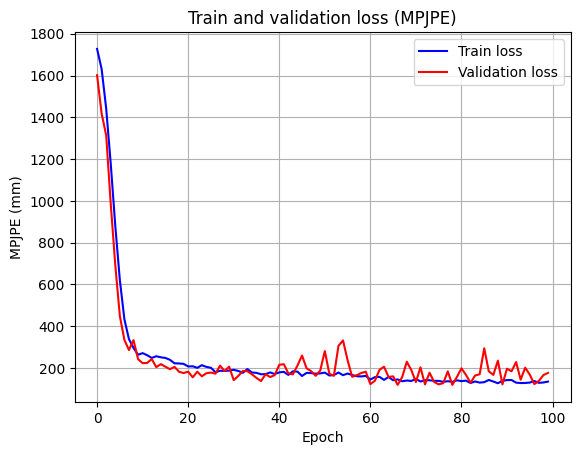

In [29]:
import matplotlib.pyplot as plt

frame_num = [i for i in range(len(val_loss_epochs))]

plt.plot(frame_num, train_loss_epochs, color='blue', label='Train loss')
plt.plot(frame_num, val_loss_epochs, color='red', label='Validation loss')

plt.title('Train and validation loss (MPJPE)')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('MPJPE (mm)')
plt.grid(True)

plt.savefig('./plots/train_val_loss.png')

plt.show()
